In [ ]:
%%writefile kaggle.json
# write "username" and "key" to json

Writing kaggle.json


Downloading the dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'potatohd404/ffhq-128-70k'
!mkdir input
!unzip "ffhq-128-70k.zip" -d input

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: input/65000/65000.png   
  inflating: input/65000/65001.png   
  inflating: input/65000/65002.png   
  inflating: input/65000/65003.png   
  inflating: input/65000/65004.png   
  inflating: input/65000/65005.png   
  inflating: input/65000/65006.png   
  inflating: input/65000/65007.png   
  inflating: input/65000/65008.png   
  inflating: input/65000/65009.png   
  inflating: input/65000/65010.png   
  inflating: input/65000/65011.png   
  inflating: input/65000/65012.png   
  inflating: input/65000/65013.png   
  inflating: input/65000/65014.png   
  inflating: input/65000/65015.png   
  inflating: input/65000/65016.png   
  inflating: input/65000/65017.png   
  inflating: input/65000/65018.png   
  inflating: input/65000/65019.png   
  inflating: input/65000/65020.png   
  inflating: input/65000/65021.png   
  inflating: input/65000/65022.png   
  inflating: input/65000/65023.png   
  inflating: input/6

Preprocessing the data

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69) # fix seed to reproduce the results


images = []
for i in range(30):
    dirname = '/content/input/' + str(i // 10) + str(i % 10) + '000'
    for f in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, f))
        images.append(img)

images = np.array(images)

In [ ]:
images.shape

(30000, 128, 128, 3)

In [ ]:
train, valid, test = images[:20000,:], images[20000:25000,:], images[25000:,:] # train, valid - for NN training,
                                                                               # test - for predicting latent space vectors     

In [ ]:
train = train / 255
valid = valid / 255
test = test / 255

In [ ]:
train.shape, test.shape, valid.shape

((20000, 128, 128, 3), (5000, 128, 128, 3), (5000, 128, 128, 3))

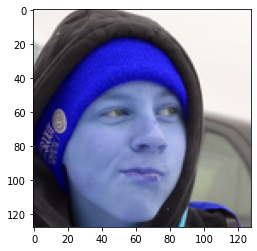

In [ ]:
plt.imshow(train[0])

In [ ]:
del images # free memory

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model


from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution() # using this func in order to use custom KL divergence loss

Building the variational autoencoder (VAE)

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 512 # Dimension of the latent vector (z)

In [ ]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides, use_batch_norm = False, use_dropout = False):
 
  global K
  K.clear_session()
 
  n_layers = len(conv_filters)
 
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input
 
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i],
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i],
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
 
      x = LeakyReLU()(x)
 
      if use_dropout:
        x = Dropout(rate=0.25)(x)
 
  shape_before_flattening = K.int_shape(x)[1:] 
 
  x = Flatten()(x)
 
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)
 
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon   
 
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
 
  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)
 
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

In [ ]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  n_layers = len(conv_filters)

  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)
 
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2])

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output) 
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

Train model 

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 100
LOSS_FACTOR = 10000
 
def kl_loss(y_true, y_pred): # special loss, required for VAEs
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss
 
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
 
adam_optimizer = Adam(lr = LEARNING_RATE)
 
vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])
 
vae_model.fit(train, train,
                epochs=N_EPOCHS,
                batch_size=128,
                shuffle=True,
                validation_data=(valid, valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
19968/20000 [============================>.] - ETA: 0s - loss: 488.8947 - r_loss: 0.0461 - kl_loss: 28.1781

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 17s 849us/sample - loss: 488.6437 - r_loss: 0.0460 - kl_loss: 28.1963 - val_loss: 350.8133 - val_r_loss: 0.0305 - val_kl_loss: 46.1803
Epoch 2/100
20000/20000 [==============================] - 13s 657us/sample - loss: 330.6113 - r_loss: 0.0281 - kl_loss: 49.5831 - val_loss: 318.7256 - val_r_loss: 0.0266 - val_kl_loss: 52.9404
Epoch 3/100
20000/20000 [==============================] - 13s 663us/sample - loss: 308.0749 - r_loss: 0.0251 - kl_loss: 56.7385 - val_loss: 306.7913 - val_r_loss: 0.0249 - val_kl_loss: 57.3729
Epoch 4/100
20000/20000 [==============================] - 13s 660us/sample - loss: 293.8041 - r_loss: 0.0234 - kl_loss: 60.0243 - val_loss: 287.3071 - val_r_loss: 0.0225 - val_kl_loss: 62.6874
Epoch 5/100
20000/20000 [==============================] - 13s 656us/sample - loss: 274.7254 - r_loss: 0.0215 - kl_loss: 59.3727 - val_loss: 266.3938 - val_r_loss: 0.0209 - val_kl_loss: 57.8651
Epoch 6/100
20000/20000 [=================

Checking the results and getting latent space vectors

In [ ]:
decoded_imgs = vae_model.predict(test) # check the results

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


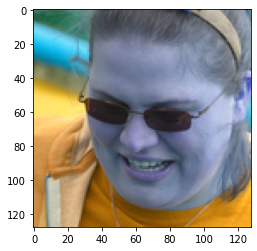

In [ ]:
plt.imshow(test[10]) # orig

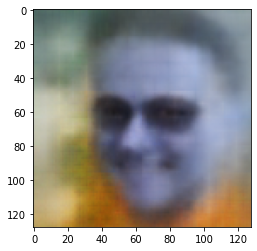

In [ ]:
plt.imshow(decoded_imgs[10]) # ...and result

In [ ]:
predict_vects = vae_encoder.predict(test) # predicting latent space vectors

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
predict_vects.shape

(5000, 512)

In [ ]:
# saving vectors to make further research

with open('ffhq_latent_vectors.npy', 'wb') as f:
    np.save(f, predict_vects)

In [ ]:
# also you can save models

vae_encoder.save('ffhq_encoder.h5')
vae_decoder.save('ffhq_decoder.h5')
vae_model.save('ffhq_model.h5')